In [37]:
import pandas as pd
import seaborn as sns
#import matplotlib as plt
import matplotlib.pyplot as plt
import os
from scipy.stats import chi2_contingency
%matplotlib inline
import numpy as np
import seaborn as sns
import igraph as ig
from scipy.spatial.distance import cdist
import netplotbrain
from nilearn import datasets
from nilearn import plotting
from scipy.stats import zscore


In [38]:
DIR=os.path.join("/NAS","tupac","protocoles","PULSE")

In [39]:
#lecture des fichiers excels
df_part = pd.read_excel(os.path.join(DIR,'Liste_participants.xlsx'))
df_cort = pd.read_excel(os.path.join(DIR,'valeurs_corticales_glasser360.xlsx'))
df_sscor2 = pd.read_excel(os.path.join(DIR,'valeurs_sous_corticales_keuken7T.xlsx'))
df_sscor1 = pd.read_excel(os.path.join(DIR,'valeurs_sous_corticales_Volbrain.xlsx'))

In [40]:
df_roi = pd.read_csv(os.path.join(DIR,'Coord_ROI_atlas_inMNI.csv'))
df_roi = df_roi.drop('Name_inPulse', axis=1)
df_roi.set_index('Name_inAtlas', inplace=True)
#df_sscor1.filter(regex="Mediane")
#[col[8:] for col in df_cort.filter(regex="Mediane").columns]

In [41]:
#Mise à jour des index
df_sscor1.set_index('Participant', inplace=True)
df_sscor2.set_index('SUBJID', inplace=True)
df_cort.set_index('SUBJID', inplace=True)
df_part.set_index('participant_id', inplace=True)

In [42]:
#création de data #filter(regex="R2")
data=df_sscor1.filter(regex="Mediane").join(df_sscor2.filter(regex="Mediane")).join(df_cort.filter(regex="Mediane"))
data.columns=df_roi.index
#df = df.rename(columns=lambda x: x.replace("Mediane ", ""))
print(data.shape)
nozero_cols = data.columns[data.all()]
data=data[nozero_cols]
df_roi=df_roi.loc[nozero_cols.values]
print(data.shape)

(181, 384)
(181, 333)


In [43]:
cols_index = list(range(24))
cols_names = ['R_4', 'L_4']
cols_to_keep = cols_index + [data.columns.get_loc(name) for name in cols_names]
print(cols_to_keep)
print(data.columns[cols_to_keep])
data = data.iloc[:, cols_to_keep]
df_roi = df_roi.iloc[cols_to_keep,:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 27, 164]
Index(['R_amygdala', 'L_amygdala', 'R_caudate', ' L_caudate', 'R_hippocampus',
       'L_hippocampus', 'R_pallidum', 'L_pallidum', 'R_putamen', 'L_putamen',
       'R_thalamus', 'L_thalamus', 'R_anterior insula', 'L_anterior insula',
       'R_posterior insula', 'L_posterior insula', 'L_RN', 'L_SN', 'L_GPe',
       'L_GPi', 'R_RN', 'R_SN', 'R_GPe', 'R_GPi', 'R_4', 'L_4'],
      dtype='object', name='Name_inAtlas')


In [44]:
df=df_part[['Declin','AGE','SEXE','SITE_APP','Score_de_declin']].dropna().join(data)
df=df.dropna()

In [45]:
def combine_gp(row):
    return row['SITE_APP'] + '_' + row['Declin']

df['Site_declin'] = df.apply(combine_gp, axis=1)


input : 
une matrice de connectivité, les noms des colonnes et les coord dans le MNI, le nom a affihcer sur la figure et le chemin pour enregistrer les screesnchots
output :
renvoie le  
affiche le nom des structures par communauté et la matrice réorganisée

In [46]:
def get_communities(matrice,df_roi,fig_title,community_pathname):
    #matrice=np.where([(matrice<-0.6) | (matrice>0.6)],matrice,0)

    # Charger la matrice de corrélation à partir d'un fichier ou d'une variable
    matrice_correlation = np.absolute(matrice)
    # Convertir la matrice de corrélation en un graphique à l'aide de igraph
    graph = ig.Graph.Weighted_Adjacency(matrice_correlation, mode="upper")

    # Effectuer la détection de communautés à l'aide de l'algorithme de Louvain
    communities = graph.community_multilevel(weights=graph.es["weight"])
    
    # Extraire les étiquettes de communauté pour chaque nœud
    node_labels1 = communities.membership
    n_communities = len(set(node_labels1))
    print(f"{n_communities} found")
    new_order=[]
    for cpt in range(n_communities):
        tmp_array=np.where(np.array(node_labels1)==cpt)
        new_order=np.concatenate([new_order,np.array(tmp_array[0])])
        print(f"ROI for community {cpt} are : {matrice.columns[tmp_array]}")
        view = plotting.view_connectome(matrice.iloc[tmp_array][matrice.columns[tmp_array]], list(df_roi.loc[matrice.columns[tmp_array]].values), edge_threshold='95%')
        view.save_as_html(os.path.join(community_pathname,f"{fig_title}_{cpt}.html"))

    matrice_com = matrice.iloc[new_order,new_order]
    plt.figure()
    sns.heatmap(matrice_com,vmin=-1, vmax=1,cbar_kws={'shrink': 0.5})
    list_com=list()
    list_com.append(0)
    for cpt in set(communities.membership):
        list_com.append(communities.membership.count(cpt))
    for cpt in np.arange(1,len(list_com)-1):
        a=np.sum(list_com[:cpt])
        b=np.sum(list_com[:cpt+1])
        c=np.sum(list_com[:cpt+2])
        plt.plot([a, c], [b, b],linestyle='-', color='green',alpha=1,linewidth=3)
        plt.plot([b, b], [a, c],linestyle='-', color='green',alpha=1,linewidth=3)
    plt.title(fig_title)
    plt.savefig(os.path.join(community_pathname,f"{fig_title}.png"), bbox_inches='tight', pad_inches=0.1)
    plt.show()

    return communities,new_order


In [51]:
def compare_matrix(matrice1,matrice2,name1,name2,nb_perm,columns,community_pathname):
    """     matrice1=matriceG1
        matrice2=matriceG2
        name1=nameG1
        name2=nameG2
        nb_perm=10
        columns=matriceG1.columns
        community_pathname=os.path.join(DIR,"screenshots")
    """
    # Calculer la distance entre les deux matrices à l'aide de la fonction cdist()
    distance_ref = cdist(matrice1.corr(), matrice2.corr(), metric='euclidean')
    #np.fill_diagonal(distance_ref, 0)

    # Afficher la matrice de distances
    print(f"Euclidean distance between {name1} and {name2} is {np.mean(distance_ref):.3f}")
    dist_list4nodes=[]
    dist_list4edges=[]

    for cpt in range(nb_perm):
        df_perm=pd.concat([matrice1,matrice2],axis=0).sample(frac=1)
        #permutations = np.random.permutation(df_perm.shape[0])
        #tableau_2d_permuted = df_perm[permutations, :]
        #=tableau_2d_permuted[:matrice1.shape[0]]
        #matrice2_tmp=tableau_2d_permuted[matrice1.shape[0]:]
        distance = cdist(df_perm.iloc[:matrice1.shape[0],:].corr(), df_perm.iloc[matrice1.shape[0]:,:].corr(), metric='euclidean')

        # Afficher la matrice de distances
        dist_list4nodes.append(np.mean(distance))
        dist_list4edges.append(distance)

    #nodes
    nb_sup=np.sum(np.array(dist_list4nodes)>=np.mean(distance_ref))
    print(f"Sur {nb_perm} seulement {nb_sup} ont une distance superieure,les deux matrices sont donc significativement différentes à p={nb_sup/nb_perm}")
    n = int(len(np.mean(distance_ref,axis=0)) * 0.05)
    indices = np.argpartition(np.mean(distance_ref,axis=0), -n)[-n:]
    indices = indices[np.argsort(np.mean(distance_ref,axis=0)[indices])[::-1]]
    print(f"Indices des 5% de nodes ayant valeurs les plus hautes : {indices} et {columns[indices]}")

    #edges
    nb_nodes=len(np.mean(distance_ref,axis=0)) 
    nb_edges = int((nb_nodes * nb_nodes - nb_nodes) /2)
    dist_sum=np.sum((np.array(dist_list4edges)<distance),axis=0)
    dist_sum=dist_sum/nb_perm

    b_fdr,ps_fdr=sm.stats.fdrcorrection(1-dist_sum.ravel(),alpha=0.05,method='indep',is_sorted=False)  
    print(f"{nb_nodes} nodes, {nb_edges} connexions, {np.sum(b_fdr)} significantly different for p_fdr < 0.05")
    mask=((np.abs(matrice1.corr()) > 0.6) | (np.abs(matrice2.corr()) > 0.6)) & (b_fdr.reshape(len(matrice1.columns),len(matrice1.columns)))
    highest_indices = np.argwhere(mask)
    nb_edges_signdiff=len(highest_indices)
    print(f"et {nb_edges_signdiff} avec des correlations >0.6 dans une des deux matrices")

    df_tmp = pd.DataFrame(data=dist_sum, columns=matrice1.columns, index=matrice1.columns) #matrice1.index)
    #np.fill_diagonal(matriceG1, 0)
    #displayed_mat = np.triu(displayed_mat,1)
    plt.figure()
    sns.heatmap(1-df_tmp.where(mask),xticklabels=columns,yticklabels=columns,vmin=-1, vmax=1,cbar_kws={'shrink': 0.5})
    plt.title(f"p_fdr < 0.05 and corr > 0.6 ")
    plt.savefig(os.path.join(community_pathname,f"{name1}_{name2}.png"), bbox_inches='tight', pad_inches=0.1)
    plt.show()
    for couple in highest_indices:
        print(f"la correlation entre {columns[couple[0]]} et {columns[couple[1]]} est de {matrice1.iloc[couple[0],couple[1]]:.3f} pour {name1} et {matrice2.iloc[couple[0],couple[1]]:.3f} pour {name2}  (p_value = {1-dist_sum[couple[0],couple[1]]:.3f})")
    return dist_sum

60 Membre inférieur ['Membre inférieur_Fast' 'Membre inférieur_Slow']
4 found
ROI for community 0 are : Index(['R_amygdala', 'L_amygdala', 'R_hippocampus', 'L_hippocampus',
       'R_thalamus', 'L_thalamus', 'R_anterior insula', 'L_anterior insula',
       'R_posterior insula', 'L_posterior insula'],
      dtype='object')
ROI for community 1 are : Index(['R_caudate', ' L_caudate', 'R_putamen', 'L_putamen', 'R_4', 'L_4'], dtype='object')
ROI for community 2 are : Index(['R_pallidum', 'L_pallidum', 'L_RN', 'L_GPe', 'L_GPi', 'R_RN', 'R_GPe',
       'R_GPi'],
      dtype='object')
ROI for community 3 are : Index(['L_SN', 'R_SN'], dtype='object')


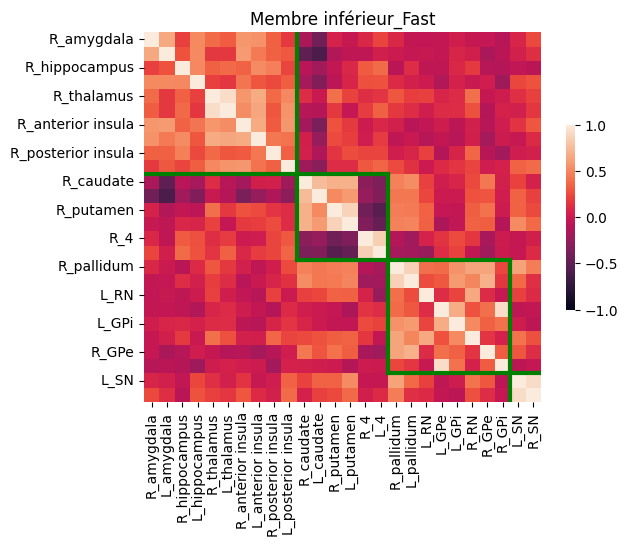

5 found
ROI for community 0 are : Index(['R_amygdala', 'R_anterior insula'], dtype='object')
ROI for community 1 are : Index(['L_amygdala', 'L_hippocampus', 'R_thalamus', 'L_thalamus',
       'L_anterior insula', 'L_posterior insula', 'R_4', 'L_4'],
      dtype='object')
ROI for community 2 are : Index(['R_caudate', ' L_caudate', 'R_pallidum', 'L_pallidum', 'R_putamen',
       'L_putamen', 'L_RN', 'R_RN', 'R_SN'],
      dtype='object')
ROI for community 3 are : Index(['R_hippocampus', 'R_posterior insula'], dtype='object')
ROI for community 4 are : Index(['L_SN', 'L_GPe', 'L_GPi', 'R_GPe', 'R_GPi'], dtype='object')


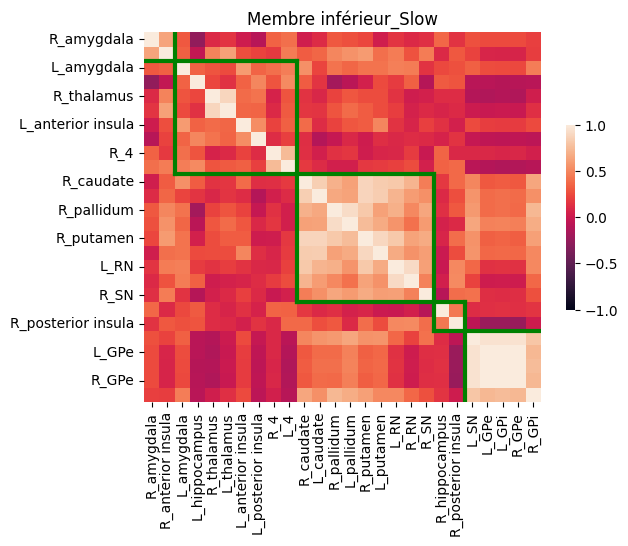

[[2. 6. 0. 2. 0.]
 [0. 2. 4. 0. 0.]
 [0. 0. 4. 0. 4.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0.]]
Euclidean distance between Membre inférieur_Fast and Membre inférieur_Slow is 2.189
Sur 10000 seulement 1560 ont une distance superieure,les deux matrices sont donc significativement différentes à p=0.156
Indices des 5% de nodes ayant valeurs les plus hautes : [8] et Index(['R_putamen'], dtype='object')
26 nodes, 325 connexions, 0 significantly different for p_fdr < 0.05
et 0 avec des correlations >0.6 dans une des deux matrices


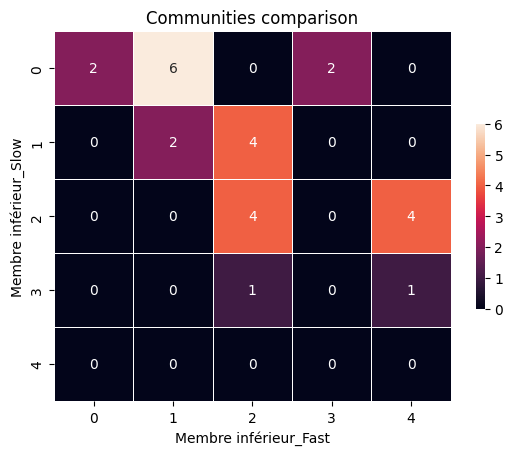

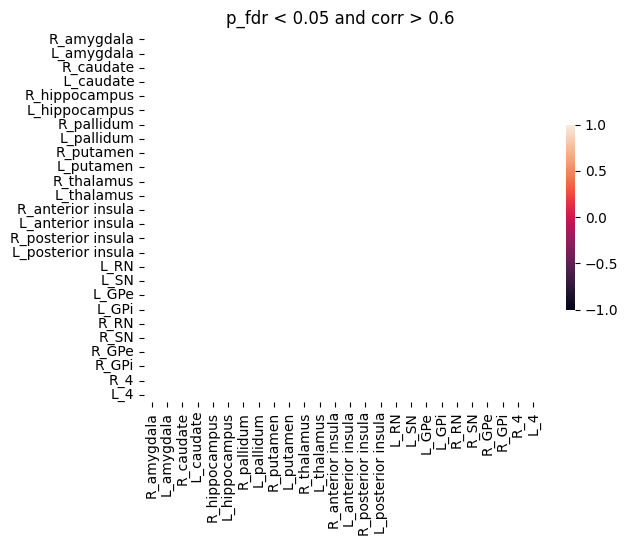

39 Bulbaire ['Bulbaire_Fast' 'Bulbaire_Slow']
7 found
ROI for community 0 are : Index(['R_amygdala', 'L_amygdala'], dtype='object')
ROI for community 1 are : Index(['R_caudate', ' L_caudate', 'R_4', 'L_4'], dtype='object')
ROI for community 2 are : Index(['R_hippocampus', 'L_hippocampus', 'R_anterior insula',
       'L_anterior insula', 'R_posterior insula', 'L_posterior insula'],
      dtype='object')
ROI for community 3 are : Index(['R_pallidum', 'L_pallidum', 'R_putamen', 'L_putamen', 'L_RN', 'R_RN'], dtype='object')
ROI for community 4 are : Index(['R_thalamus', 'L_thalamus'], dtype='object')
ROI for community 5 are : Index(['L_SN', 'R_SN', 'R_GPe'], dtype='object')
ROI for community 6 are : Index(['L_GPe', 'L_GPi', 'R_GPi'], dtype='object')


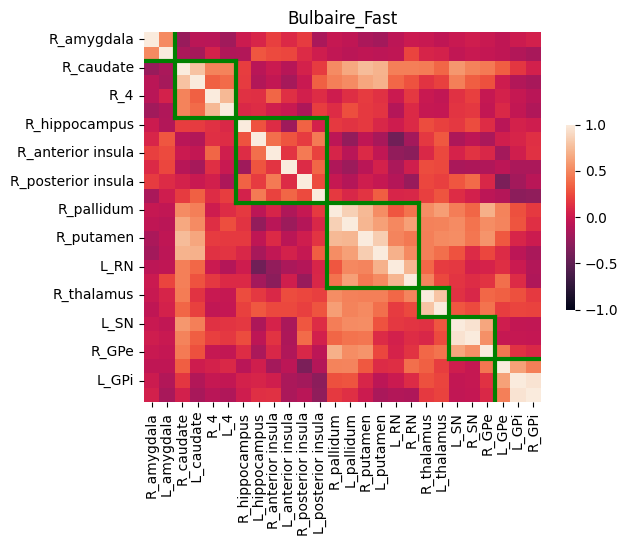

4 found
ROI for community 0 are : Index(['R_amygdala', 'L_amygdala', 'L_putamen', 'R_thalamus',
       'L_anterior insula'],
      dtype='object')
ROI for community 1 are : Index(['R_caudate', 'R_hippocampus', 'L_SN', 'L_GPe', 'L_GPi', 'R_SN', 'R_4',
       'L_4'],
      dtype='object')
ROI for community 2 are : Index([' L_caudate', 'L_hippocampus', 'R_putamen', 'R_anterior insula',
       'L_posterior insula', 'L_RN', 'R_RN', 'R_GPe', 'R_GPi'],
      dtype='object')
ROI for community 3 are : Index(['R_pallidum', 'L_pallidum', 'L_thalamus', 'R_posterior insula'], dtype='object')


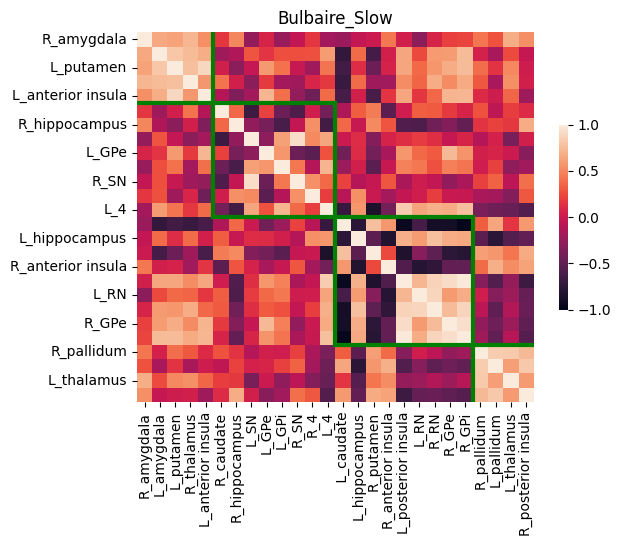

[[2. 0. 0. 0. 0. 0. 0.]
 [0. 3. 1. 0. 0. 0. 0.]
 [1. 1. 3. 1. 0. 0. 0.]
 [1. 0. 3. 2. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [0. 2. 1. 0. 0. 0. 0.]
 [0. 2. 1. 0. 0. 0. 0.]]
Euclidean distance between Bulbaire_Fast and Bulbaire_Slow is 2.910
Sur 10000 seulement 1289 ont une distance superieure,les deux matrices sont donc significativement différentes à p=0.1289
Indices des 5% de nodes ayant valeurs les plus hautes : [3] et Index([' L_caudate'], dtype='object')
26 nodes, 325 connexions, 0 significantly different for p_fdr < 0.05
et 0 avec des correlations >0.6 dans une des deux matrices


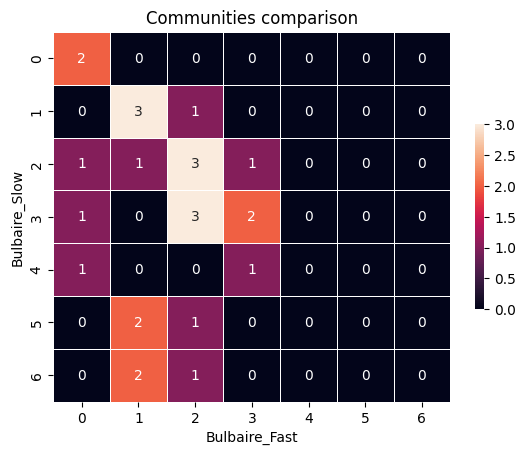

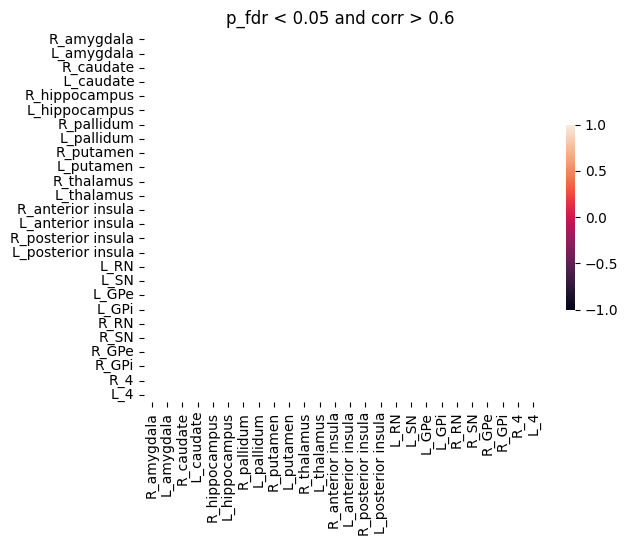

74 Membre supérieur ['Membre supérieur_Fast' 'Membre supérieur_Slow']
4 found
ROI for community 0 are : Index(['R_amygdala', 'L_amygdala', 'R_4', 'L_4'], dtype='object')
ROI for community 1 are : Index(['R_caudate', ' L_caudate', 'R_pallidum', 'L_pallidum', 'R_putamen',
       'L_putamen', 'L_RN', 'L_SN', 'L_GPi', 'R_RN', 'R_SN', 'R_GPe'],
      dtype='object')
ROI for community 2 are : Index(['R_hippocampus', 'L_hippocampus', 'R_thalamus', 'L_thalamus',
       'L_anterior insula', 'R_posterior insula', 'L_posterior insula',
       'L_GPe'],
      dtype='object')
ROI for community 3 are : Index(['R_anterior insula', 'R_GPi'], dtype='object')


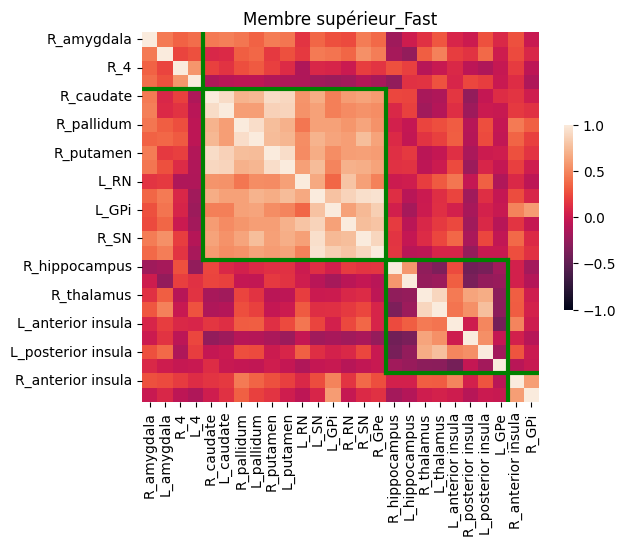

4 found
ROI for community 0 are : Index(['R_amygdala', 'R_caudate', ' L_caudate', 'R_pallidum', 'L_pallidum',
       'R_putamen', 'L_putamen', 'L_SN', 'R_SN'],
      dtype='object')
ROI for community 1 are : Index(['L_amygdala', 'R_4', 'L_4'], dtype='object')
ROI for community 2 are : Index(['R_hippocampus', 'L_hippocampus', 'R_thalamus', 'L_thalamus',
       'R_anterior insula', 'L_anterior insula', 'R_posterior insula',
       'L_posterior insula', 'L_RN', 'R_RN'],
      dtype='object')
ROI for community 3 are : Index(['L_GPe', 'L_GPi', 'R_GPe', 'R_GPi'], dtype='object')


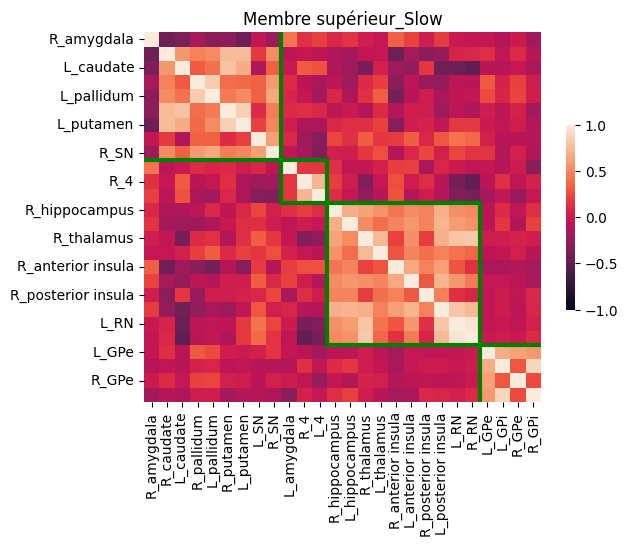

[[1. 3. 0. 0.]
 [8. 0. 2. 2.]
 [0. 0. 7. 1.]
 [0. 0. 1. 1.]]
Euclidean distance between Membre supérieur_Fast and Membre supérieur_Slow is 2.454
Sur 10000 seulement 896 ont une distance superieure,les deux matrices sont donc significativement différentes à p=0.0896
Indices des 5% de nodes ayant valeurs les plus hautes : [15] et Index(['L_posterior insula'], dtype='object')
26 nodes, 325 connexions, 0 significantly different for p_fdr < 0.05
et 0 avec des correlations >0.6 dans une des deux matrices


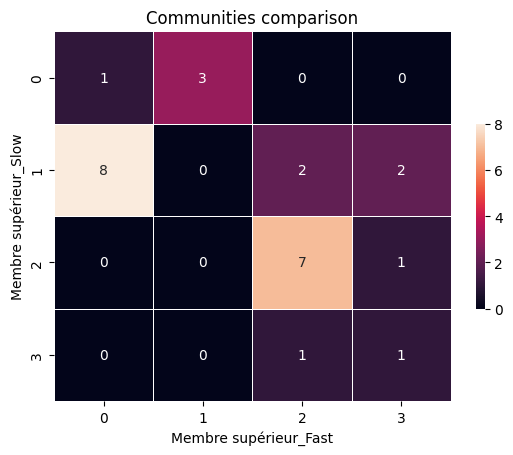

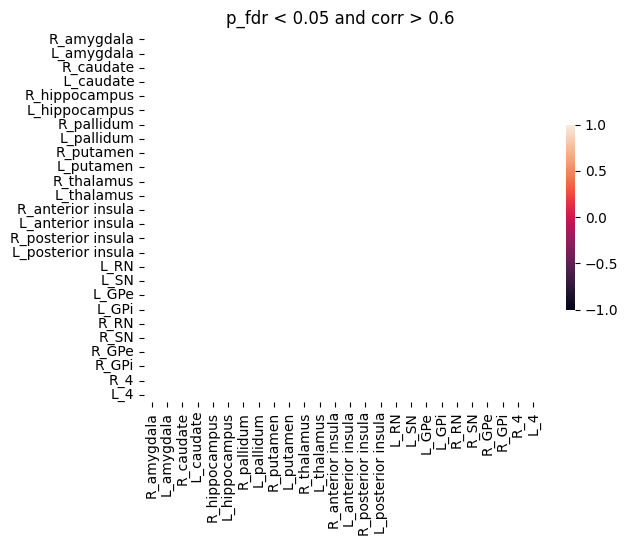

In [53]:
pmat_list=[]
for SITE_APP in df['SITE_APP'].unique():
    df_perm=df.loc[df['SITE_APP']==SITE_APP];   
    print(len(df_perm),SITE_APP,np.unique(df_perm['Site_declin']))

    nameG1=np.unique(df_perm['Site_declin'])[0]
    df_tmp=df_perm.loc[df['Site_declin']==nameG1]
    matriceG1 = df_tmp.drop(columns=['Declin','AGE','SEXE','SITE_APP','Score_de_declin','Site_declin'])
    #matriceG1=zscore(matriceG1)

    # Créer un tableau diagonal avec la valeur 0
    #diag_vals = np.diag(np.zeros(matriceG1.shape[0]))

    # Remplir la diagonale du DataFrame avec la valeur 0
    #matriceG1.values[np.diag_indices(matriceG1.shape[0])] = diag_vals.diagonal()
    communities1,new_order1=get_communities(matriceG1.corr(),df_roi,nameG1,os.path.join(DIR,"screenshots"))

    nameG2=np.unique(df_perm['Site_declin'])[1]
    df_tmp=df_perm.loc[df['Site_declin']==np.unique(df_perm['Site_declin'])[1]]
    matriceG2 = df_tmp.drop(columns=['Declin','AGE','SEXE','SITE_APP','Score_de_declin','Site_declin'])
    #matriceG2=zscore(matriceG2)

    # Créer un tableau diagonal avec la valeur 0
    #diag_vals = np.diag(np.zeros(matriceG2.shape[0]))

    # Remplir la diagonale du DataFrame avec la valeur 0
    #matriceG2.values[np.diag_indices(matriceG2.shape[0])] = diag_vals.diagonal()
    communities2,new_order2=get_communities(matriceG2.corr(),df_roi,nameG2,os.path.join(DIR,"screenshots"))

    bins = np.arange(0,np.max([len(set(communities1.membership)),len(set(communities2.membership))])+1)
    mat_confusion, _, _ =np.histogram2d(communities1.membership, communities2.membership, bins=[bins, bins])    
    print(mat_confusion)
    plt.figure()
    sns.heatmap(mat_confusion,annot=True,cbar_kws={'shrink': 0.5},linewidths=0.5)
    plt.title(f"Communities comparison")
    plt.xlabel(nameG1)
    plt.ylabel(nameG2)
    plt.savefig(os.path.join(os.path.join(DIR,"screenshots"),f"confusionMat4_{nameG1}_{nameG2}.png"), bbox_inches='tight', pad_inches=0.1)
    pmat=compare_matrix(matriceG1,matriceG2,nameG1,nameG2,10000,matriceG1.columns,os.path.join(DIR,"screenshots"))
    pmat_list.append(pmat)
